In [17]:
using Revise
using Printf, Plots
import StructArrays: StructArray, StructVector

using MutableNamedTuples

using Serialization
include("CaOH_simulation_toolbox.jl")


# Import the packages required for the notebook
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

# A few constants used for the simulation
λ = 663.3e-9
Γ = 2π * 6.6e6 # in units of MHz
m = @with_unit 107 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)

;

In [18]:
# Comparing energy levels to analytic solutions (Eq 4.3 in David Glenn's thesis)
# BX = 0.25359 * 299792458 * 1e-4
# DX = 2.49e-7 * 299792458 * 1e-4
# γX = 74.79485
# bFX = 97.0834 
# cX = 30.268

# N = 1

# E1_12_1 = -(γX+bFX)/4 - 1/4*sqrt((2*N+1)^2*γX^2 -2*γX*(2*bFX+cX) + (2*bFX+cX)^2)
# E1_12_0 = - (γX/2)*(N+1)+bFX/4 - cX/4/(2*N-1)

# E1_12_0 - E1_12_1

In [19]:
SrF_package = get_SrF_Hamiltonian()
states = SrF_package.states
d = SrF_package.d

energy.(states)./1e6 .- energy(states[1])/1e6

16-element Vector{Float64}:
   0.0
   0.0006609033389395336
   0.001321812253081589
  49.66071733901663
 129.56228727936286
 129.5636488325781
 129.56501033926907
 170.93126624717297
 170.93196688002536
 170.93266750686962
 170.9333681276512
 170.93406874221364
   4.4762540034582025e8
   4.4762540034582025e8
   4.4762540034582025e8
   4.4762540034582025e8

In [20]:
J12_F1_energy = energy(states[1])
J12_F0_energy = energy(states[4])
J32_F1_energy = energy(states[5])
J32_F2_energy = energy(states[8])
A_energy = energy(states[13])




s_J12_F1 = 5 * 60/31
δ_J12_F1 = +2.0Γ
pol_J12_F1 = σ⁻
ω_J12_F1 = 2π * (A_energy - J12_F1_energy) + δ_J12_F1

s_J12_F0 = 1 * 60/31
δ_J12_F0 = -0.5Γ 
pol_J12_F0 = σ⁺
ω_J12_F0 = 2π * (A_energy - J12_F0_energy) + δ_J12_F0


s_J32_F1 = 5 * 60/31
δ_J32_F1 = +3.0Γ 
pol_J32_F1 = σ⁻
ω_J32_F1 = 2π * (A_energy - J32_F1_energy) + δ_J32_F1

s_J32_F2 = 20 * 60/31
δ_J32_F2 = +4.0Γ
pol_J32_F2 = σ⁺
ω_J32_F2 = 2π * (A_energy - J32_F2_energy) + δ_J32_F2

# This function sets the polarization as a function of time; here it's just set to be constant
ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ(rotate_pol(pol_J12_F1, +x̂)); laser1 = Field(+x̂, ϵ1, ω_J12_F1, s_J12_F1)
ϵ2 = ϵ(rotate_pol(pol_J12_F1, -x̂)); laser2 = Field(-x̂, ϵ2, ω_J12_F1, s_J12_F1)
ϵ3 = ϵ(rotate_pol(pol_J12_F1, +ŷ)); laser3 = Field(+ŷ, ϵ3, ω_J12_F1, s_J12_F1)
ϵ4 = ϵ(rotate_pol(pol_J12_F1, -ŷ)); laser4 = Field(-ŷ, ϵ4, ω_J12_F1, s_J12_F1)
ϵ5 = ϵ(rotate_pol(pol_J12_F1, +ẑ)); laser5 = Field(+ẑ, ϵ5, ω_J12_F1, s_J12_F1)
ϵ6 = ϵ(rotate_pol(pol_J12_F1, -ẑ)); laser6 = Field(-ẑ, ϵ6, ω_J12_F1, s_J12_F1)
lasers_J12_F1 = [laser1, laser2, laser3, laser4, laser5, laser6]

ϵ7  = ϵ(rotate_pol(pol_J12_F0, +x̂)); laser7  = Field(+x̂, ϵ7,  ω_J12_F0, s_J12_F0)
ϵ8  = ϵ(rotate_pol(pol_J12_F0, -x̂)); laser8  = Field(-x̂, ϵ8,  ω_J12_F0, s_J12_F0)
ϵ9  = ϵ(rotate_pol(pol_J12_F0, +ŷ)); laser9  = Field(+ŷ, ϵ9,  ω_J12_F0, s_J12_F0)
ϵ10 = ϵ(rotate_pol(pol_J12_F0, -ŷ)); laser10 = Field(-ŷ, ϵ10, ω_J12_F0, s_J12_F0)
ϵ11 = ϵ(rotate_pol(pol_J12_F0, +ẑ)); laser11 = Field(+ẑ, ϵ11, ω_J12_F0, s_J12_F0)
ϵ12 = ϵ(rotate_pol(pol_J12_F0, -ẑ)); laser12 = Field(-ẑ, ϵ12, ω_J12_F0, s_J12_F0)
lasers_J12_F0 = [laser7, laser8, laser9, laser10, laser11, laser12]

ϵ13  = ϵ(rotate_pol(pol_J32_F1, +x̂)); laser13  = Field(+x̂, ϵ13,  ω_J32_F1, s_J32_F1)
ϵ14 = ϵ(rotate_pol(pol_J32_F1, -x̂)); laser14 = Field(-x̂, ϵ14,  ω_J32_F1, s_J32_F1)
ϵ15 = ϵ(rotate_pol(pol_J32_F1, +ŷ)); laser15 = Field(+ŷ, ϵ15,  ω_J32_F1, s_J32_F1)
ϵ16 = ϵ(rotate_pol(pol_J32_F1, -ŷ)); laser16 = Field(-ŷ, ϵ16, ω_J32_F1, s_J32_F1)
ϵ17 = ϵ(rotate_pol(pol_J32_F1, +ẑ)); laser17 = Field(+ẑ, ϵ17, ω_J32_F1, s_J32_F1)
ϵ18 = ϵ(rotate_pol(pol_J32_F1, -ẑ)); laser18 = Field(-ẑ, ϵ18, ω_J32_F1, s_J32_F1)
lasers_J32_F1 = [laser13, laser14, laser15, laser16, laser17, laser18]

ϵ19  = ϵ(rotate_pol(pol_J32_F2, +x̂)); laser19  = Field(+x̂, ϵ19, ω_J32_F2, s_J32_F2)
ϵ20 = ϵ(rotate_pol(pol_J32_F2, -x̂)); laser20 = Field(-x̂, ϵ20, ω_J32_F2, s_J32_F2)
ϵ21 = ϵ(rotate_pol(pol_J32_F2, +ŷ)); laser21 = Field(+ŷ, ϵ21,  ω_J32_F2, s_J32_F2)
ϵ22 = ϵ(rotate_pol(pol_J32_F2, -ŷ)); laser22 = Field(-ŷ, ϵ22, ω_J32_F2, s_J32_F2)
ϵ23 = ϵ(rotate_pol(pol_J32_F2, +ẑ)); laser23 = Field(+ẑ, ϵ23, ω_J32_F2, s_J32_F2)
ϵ24 = ϵ(rotate_pol(pol_J32_F2, -ẑ)); laser24 = Field(-ẑ, ϵ24, ω_J32_F2, s_J32_F2)
lasers_J32_F2 = [laser19, laser20, laser21, laser22, laser23, laser24]



lasers = [lasers_J12_F1; lasers_J12_F0; lasers_J32_F1; lasers_J32_F2]
;

In [21]:
# prob.p.Js

In [22]:
(prob.p.fields.E).⋅(prob.p.fields.E)

LoadError: UndefVarError: `prob` not defined

In [23]:
rotate_pol([0,0,1], +x̂)

3-element SVector{3, ComplexF64} with indices SOneTo(3):
   0.49999999999999994 + 0.0im
 4.329780281177467e-17 - 0.7071067811865476im
                  -0.5 - 6.123233995736766e-17im

In [24]:
rotate_pol([0,0,1],-x̂)

3-element SVector{3, ComplexF64} with indices SOneTo(3):
   0.49999999999999994 + 0.0im
 4.329780281177467e-17 + 0.7071067811865476im
                  -0.5 + 6.123233995736766e-17im

In [25]:
freq_res = 1e-2
B = 0.0

particle = Particle()
ρ0 = zeros(ComplexF64, length(states), length(states)) 
ρ0[2,2] = 1.0

extra_p = MutableNamedTuple(Ham_X=SrF_package.Ham_X, lasers = lasers,
            X_states = states[1:12], A_states = states[13:end], 
            basis_tdms = SrF_package.basis_tdms,
            current_config= Dict{String, Int32}(),
            Γ = Γ,
            λ = λ
            )


# vs = [0; exp10.(collect(LinRange(-1.5,0.2,10)))./ (Γ / k)]

# Bs_temp = exp10.(collect(LinRange(-2,0.2,10)))
# Bs = [reverse(Bs_temp).*(-1); 0; Bs_temp]


p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)
p = remake_obe_B(p, 1e-6)
p.v = (0., 0., 0.) ./(Γ / k)
p.r0 = (0., 0.,  1)
p.v = round_vel(p.v, p.freq_res)
println(p.v*(Γ / k))
t_end = 10p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)

prob.p.force_last_period = (0, 0, 0);

[0.0, 0.0, 0.0]


In [26]:
# p1 = remake_obe_B(p, 1);
# p.ω

In [27]:
p.ω

16-element Vector{Float64}:
 2287.44
 2287.44
 2287.44
 2294.96
 2307.07
 2307.07
 2307.07
 2313.34
 2313.34
 2313.34
 2313.34
 2313.34
    6.782431779e7
    6.782431779e7
    6.782431779e7
    6.782431779e7

In [28]:
function reset_force1!(integrator)
    force_current_period = integrator.u[end-2:end] / integrator.p.period
    force_diff = abs(norm(force_current_period) - norm(integrator.p.force_last_period))
    force_diff_rel = force_diff / norm(integrator.p.force_last_period)
    integrator.p.force_last_period = force_current_period
    
    n = length(integrator.p.states)^2
    integrator.p.populations .= integrator.u[n+1:end-3] / integrator.p.period

    force_reltol = 1e-4
    if (force_diff_rel < force_reltol) #|| (force_diff < 1e-6)
        terminate!(integrator)
    else
        integrator.u[end-2:end] .= 0.0
        integrator.u[n+1:end-3] .= 0.0
    end
    return nothing
end

reset_force1! (generic function with 1 method)

 29.230993 seconds (13.36 M allocations: 1.679 GiB, 2.32% gc time, 73.27% compilation time)
[-0.02552512865989348, -0.005438468470393331, -9696.762044117897]


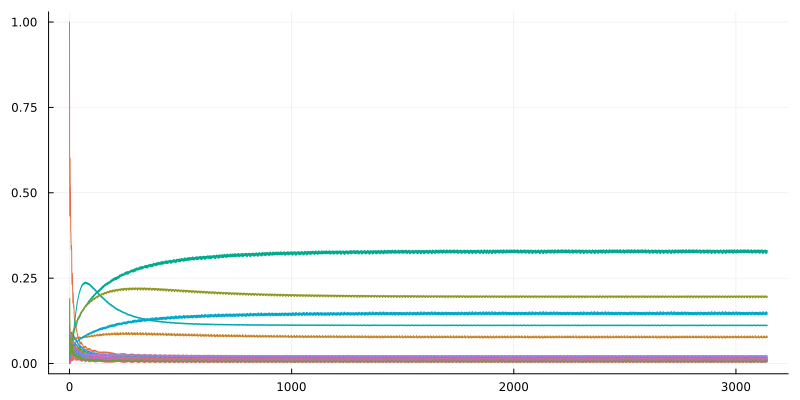

In [29]:
cb = PeriodicCallback(reset_force1!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, reltol=1e-4)
plot_us = sol.u[1:10:end]
plot_ts = sol.t[1:10:end]

println(prob.p.force_last_period .* (ħ* k * Γ/m))

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()

In [30]:
sum(prob.p.populations)

1.0000000871515795 + 0.0im

In [31]:
prob.p.Js

108-element Vector{OpticalBlochEquations.Jump}:
 OpticalBlochEquations.Jump(13, 1, -1, 9.256728405360856e-9 + 0.0im)
 OpticalBlochEquations.Jump(13, 1, 0, 8.286544502313115e-7 + 0.0im)
 OpticalBlochEquations.Jump(13, 1, 1, -0.26536781420690625 + 0.0im)
 OpticalBlochEquations.Jump(14, 1, -1, 1.727573989993203e-8 + 0.0im)
 OpticalBlochEquations.Jump(14, 1, 1, 0.49525338566522864 + 0.0im)
 OpticalBlochEquations.Jump(15, 1, 0, -1.7275699386808668e-8 + 0.0im)
 OpticalBlochEquations.Jump(15, 1, 1, -1.5465097872513007e-6 + 0.0im)
 OpticalBlochEquations.Jump(16, 1, -1, 1.546509798462738e-6 + 0.0im)
 OpticalBlochEquations.Jump(16, 1, 0, -0.49525338972516214 + 0.0im)
 OpticalBlochEquations.Jump(13, 2, -1, 6.335674807974213e-7 + 0.0im)
 OpticalBlochEquations.Jump(13, 2, 0, 0.265367813073719 + 0.0im)
 OpticalBlochEquations.Jump(13, 2, 1, 7.865300585691009e-7 + 0.0im)
 OpticalBlochEquations.Jump(14, 2, -1, 1.182420882909876e-6 + 0.0im)
 ⋮
 OpticalBlochEquations.Jump(16, 11, -1, 3.4712258387855295e-

In [14]:
using Interpolations
using ImageFiltering

function get_acceleration_func_test(test_i, var="v")
    
    dir = @sprintf("SrF_blueMOT_test%d", test_i)



    acceleration = deserialize(joinpath(dir, @sprintf("SrF_blueMOT_test%d_avg_acceleration.jl", test_i)))
    populations = deserialize(joinpath(dir, @sprintf("SrF_blueMOT_test%d_avg_populations.jl", test_i)))
    scan_values = deserialize(joinpath(dir, @sprintf("SrF_blueMOT_test%d_shortened_scan_values.jl", test_i)))

    if var == "v"
        nodes = (scan_values["v"].* (Γ / k), )
    elseif var == "B"
        nodes = (scan_values["B"], )
    end

    acceleration_func = interpolate(nodes, acceleration*(Γ^2 / k), Gridded(Linear()))

    smooth_acceleration_grids = imfilter(acceleration, Kernel.gaussian([0.5,]))
    smooth_acceleration_func = interpolate(nodes, smooth_acceleration_grids*(Γ^2 / k), Gridded(Linear()))
    smooth_acceleration_func = extrapolate(smooth_acceleration_func, Linear());
        
    return acceleration_func
end;

In [15]:
collect(keys(scan_values))[1]

LoadError: UndefVarError: scan_values not defined

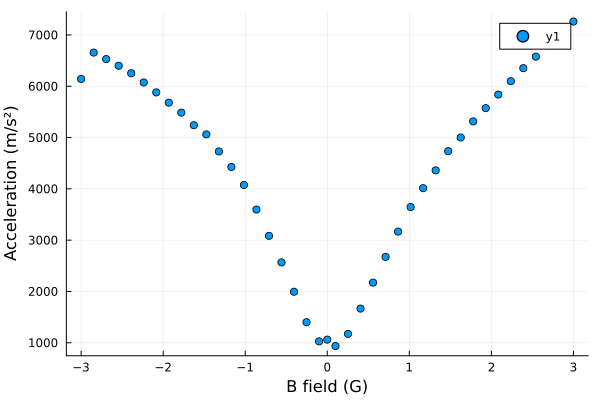

In [95]:
test_i = 30
scanned_var = "B"

dir = @sprintf("SrF_blueMOT_test%d", test_i)

smooth_acceleration_func = get_acceleration_func_test(test_i,scanned_var)
scan_values = deserialize(joinpath(dir, @sprintf("SrF_blueMOT_test%d_shortened_scan_values.jl", test_i)))
plot()
if scanned_var == "v"
    y = scan_values["v"].* (Γ / k)
    plot!(xlabel="velocity (m/s)", ylabel="Acceleration (m/s²)")
elseif scanned_var == "B"
    y = scan_values["B"]
    plot!(xlabel="B field (G)", ylabel="Acceleration (m/s²)")
end

scatter!(y, smooth_acceleration_func(y))

In [ ]:
SrF_package = get_SrF_Hamiltonian()
states = SrF_package.states
HX = SrF_package.Ham_X
HA = SrF_package.Ham_A

J12_F1_energy = energy(states[1])
J12_F0_energy = energy(states[4])
J32_F1_energy = energy(states[5])
J32_F2_energy = energy(states[8])
A_energy = energy(states[13])



s_J12_F1 = 5 * 60/31
δ_J12_F1 = +2.0Γ
pol_J12_F1 = σ⁻
ω_J12_F1 = 2π * (A_energy - J12_F1_energy) + δ_J12_F1

s_J12_F0 = 1 * 60/31
δ_J12_F0 = -0.5Γ 
pol_J12_F0 = σ⁺
ω_J12_F0 = 2π * (A_energy - J12_F0_energy) + δ_J12_F0


s_J32_F1 = 5 * 60/31
δ_J32_F1 = +3.0Γ 
pol_J32_F1 = σ⁻
ω_J32_F1 = 2π * (A_energy - J32_F1_energy) + δ_J32_F1

s_J32_F2 = 20 * 60/31
δ_J32_F2 = +4.0Γ
pol_J32_F2 = σ⁺
ω_J32_F2 = 2π * (A_energy - J32_F2_energy) + δ_J32_F2


function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    for i ∈ eachindex(H.states)
        H.states[i].E *= 1e6
    end
    return nothing
end


Bs = (0:0.1:10) #.+ 1e-3
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(HA, scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)

using Plots
scan_matrix = hcat(values(scan_values)...)'
;

## N=1 ground states have index 5:16;

plot(Bs, (scan_matrix[:,5:8].-scan_matrix[1,5])./1e6, xlabel="B field (G)", ylabel="Energy (MHz)")

#plot(Bs, scan_matrix[:,5:7]./1e6, xlabel="B field (G)", ylabel="Energy (MHz)")

# hline!(
#         [(J12_F1_energy - δ_J12_F1/ 2π)/1e6], 
#     linestyle=:dash,
#     color=:red,
#     label="one-photon resonance"
#     )

# hline!(
#         [(J12_F0_energy - δ_J12_F0/ 2π)/1e6], 
#     linestyle=:dash,
#     color=:red,
#     label="one-photon resonance"
#     )

# hline!(
#         [(J32_F1_energy - δ_J32_F1/ 2π)/1e6], 
#     linestyle=:dash,
#     color=:red,
#     label="one-photon resonance"
#     )

# hline!(
#         [(J32_F2_energy - δ_J32_F2/ 2π)/1e6], 
#     linestyle=:dash,
#     color=:red,
#     label="one-photon resonance"
#     )
plot!(legend=false)


In [ ]:
h * (15097 - 15089.5)*1e6 / (10e-4) /μ_B

In [ ]:
SrF_package = get_SrF_Hamiltonian()
states = SrF_package.states
HX = SrF_package.Ham_X
HA = SrF_package.Ham_A

H = HA
H.parameters.B_z = 1e-2
evaluate!(H)
QuantumStates.solve!(H)
H.states[5]

In [ ]:
H.states[5]⋅H.states[5]

In [ ]:
H.states[6]

In [ ]:
H.states[7]

In [ ]:
H.states[8]

In [ ]:

# function get_SrF_Hamiltonian()
#     # X states
#     HX_operator = :(
#         BX * Rotation + 
#         DX * RotationDistortion + 
#         γX * SpinRotation + 
#         bFX * Hyperfine_IS + 
#         cX * (Hyperfine_Dipolar/3)
#     )

#     parameters = @params begin
#         BX = 0.25359 * 299792458 * 1e-4
#         DX = 2.49e-7 * 299792458 * 1e-4
#         γX = 74.79485
#         bFX = 97.0834 + 30.268/3
#         cX = 30.268
#     end

#     QN_bounds = (S=1/2, I=1/2, Λ=0, N=0:3)
#     basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

#     SrF_000_N0to3_Hamiltonian = Hamiltonian(basis=basis, operator=HX_operator, parameters=parameters)

#     # Add Zeeman term
#     _μB = (μ_B / h) * (1e-6 * 1e-4)
#     Zeeman_z(state, state′) = Zeeman(state, state′, 0)
#     SrF_000_N0to3_Hamiltonian = add_to_H(SrF_000_N0to3_Hamiltonian, :B_z, gS * _μB * Zeeman_z)
#     SrF_000_N0to3_Hamiltonian.parameters.B_z = 1e-6 #todo

#     full_evaluate!(SrF_000_N0to3_Hamiltonian)
#     QuantumStates.solve!(SrF_000_N0to3_Hamiltonian)
#     ;


#     # A states
#     H_operator = :(
#         T_A * DiagonalOperator +
#         Be_A * Rotation + 
#         Aso_A * SpinOrbit + 
#         q_A * ΛDoubling_q +
#         p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q) +
#         temp * Hyperfine_IF
#     )

#     parameters = @params begin
#         T_A = 15072.09 * 299792458 * 1e-4
#         Be_A =  0.2536135 * 299792458 * 1e-4
#         Aso_A = 281.46138 * 299792458 * 1e-4
#         p_A = -0.133002 * 299792458 * 1e-4
#         q_A = -0.3257e-3 * 299792458 * 1e-4
#         temp = 0
#     end

#     QN_bounds = (S=1/2, I=1/2, Λ=(-1,1), J=1/2:5/2)
#     basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

#     gL = 1
#     gL_prime = -0.083*3 #SrF
#     Zeeman_A(state, state1) = gL * _μB * Zeeman_L(state, state1) + gS * _μB * Zeeman_S(state, state1) + gL_prime * _μB * Zeeman_glprime(state, state1)
#     SrF_A000_J12to52_Hamiltonian = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
#     SrF_A000_J12to52_Hamiltonian = add_to_H(SrF_A000_J12to52_Hamiltonian, :B_z, Zeeman_A)
#     SrF_A000_J12to52_Hamiltonian.parameters.B_z = 5.0

#     evaluate!(SrF_A000_J12to52_Hamiltonian)
#     QuantumStates.solve!(SrF_A000_J12to52_Hamiltonian)
#     ;

#     HA_J12_pos_parity_states = SrF_A000_J12to52_Hamiltonian.states[5:8]

#     QN_bounds = (S=1/2, I=1/2, Λ=(-1,1), N=0:2)
#     basis_to_convert = enumerate_states(HundsCaseB_Rot, QN_bounds)

#     states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, basis_to_convert)
#     ;

#     _, HX_N1_states = subspace(SrF_000_N0to3_Hamiltonian.states, (N=1,))
#     states = [HX_N1_states; states_A_J12_caseB]
#     for state ∈ states
#         state.E *= 1e6
#     end
#     ;

#     # Calculate transtion dipole moment between X and A states:
#     d = zeros(ComplexF64, 16, 16, 3)
#     d_ge = zeros(ComplexF64, 12, 4, 3)
#     basis_tdms = get_tdms_two_bases(SrF_000_N0to3_Hamiltonian.basis, basis_to_convert, TDM)
#     tdms_between_states!(d_ge, basis_tdms, HX_N1_states, states_A_J12_caseB)
#     d[1:12, 13:16, :] .= d_ge
#     ;

#     return MutableNamedTuple(Ham_X=SrF_000_N0to3_Hamiltonian, Ham_A = SrF_A000_J12to52_Hamiltonian, states=states, d=d, basis_tdms=basis_tdms)
# end

In [ ]:
function get_SrF_Hamiltonian()
    # X states
    HX_operator = :(
        BX * Rotation + 
        DX * RotationDistortion + 
        γX * SpinRotation + 
        bFX * Hyperfine_IS + 
        cX * (Hyperfine_Dipolar/3)
    )

    parameters = @params begin
        BX = 0.25359 * 299792458 * 1e-4
        DX = 2.49e-7 * 299792458 * 1e-4
        γX = 74.79485
        bFX = 97.0834 + 30.268/3
        cX = 30.268
    end

    QN_bounds = (S=1/2, I=1/2, Λ=0, N=0:3)
    basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

    SrF_000_N0to3_Hamiltonian = Hamiltonian(basis=basis, operator=HX_operator, parameters=parameters)

    # Add Zeeman term
    _μB = (μ_B / h) * (1e-6 * 1e-4)
    Zeeman_z(state, state′) = Zeeman(state, state′, 0)
    SrF_000_N0to3_Hamiltonian = add_to_H(SrF_000_N0to3_Hamiltonian, :B_z, gS * _μB * Zeeman_z)
    SrF_000_N0to3_Hamiltonian.parameters.B_z = 1e-3 #todo

    full_evaluate!(SrF_000_N0to3_Hamiltonian)
    QuantumStates.solve!(SrF_000_N0to3_Hamiltonian)
    ;


    # A states
    H_operator = :(
        T_A * DiagonalOperator +
        Be_A * Rotation + 
        Aso_A * SpinOrbit + 
        q_A * ΛDoubling_q +
        p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q) + 
        temp * Hyperfine_IF
    ) # had to add a small hyperfine splitting so that when zeeman terms are added, mF remains a good quantum number 
    # (breaks degeneracy between hyperfine states so that the eigenstates of H found by solver are eigenstates of m)

    parameters = @params begin
        T_A = 15072.09 * 299792458 * 1e-4
        Be_A =  0.2536135 * 299792458 * 1e-4
        Aso_A = 281.46138 * 299792458 * 1e-4
        p_A = -0.133002 * 299792458 * 1e-4
        q_A = -0.3257e-3 * 299792458 * 1e-4
        temp = 1e-4
    end

    QN_bounds = (S=1/2, I=1/2, Λ=(-1,1), J=1/2:5/2)
    basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

    gL = 1
    gL_prime = -0.083*3 #SrF
    Zeeman_A(state, state1) = gL * _μB * Zeeman_L(state, state1) + gS * _μB * Zeeman_S(state, state1) + gL_prime * _μB * Zeeman_glprime(state, state1)
    SrF_A000_J12to52_Hamiltonian = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
#     SrF_A000_J12to52_Hamiltonian = add_to_H(SrF_A000_J12to52_Hamiltonian, :B_z, Zeeman_A)
#     SrF_A000_J12to52_Hamiltonian.parameters.B_z = 1e-3

    evaluate!(SrF_A000_J12to52_Hamiltonian)
    QuantumStates.solve!(SrF_A000_J12to52_Hamiltonian)
    ;

    HA_J12_pos_parity_states = SrF_A000_J12to52_Hamiltonian.states[5:8]

    QN_bounds = (S=1/2, I=1/2, Λ=(-1,1), N=0:2)
    basis_to_convert = enumerate_states(HundsCaseB_Rot, QN_bounds)

    states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, basis_to_convert)
    ;

    _, HX_N1_states = subspace(SrF_000_N0to3_Hamiltonian.states, (N=1,))
    states = [HX_N1_states; states_A_J12_caseB]
    for state ∈ states
        state.E *= 1e6
    end
    ;

    # Calculate transtion dipole moment between X and A states:
    d = zeros(ComplexF64, 16, 16, 3)
    d_ge = zeros(ComplexF64, 12, 4, 3)
    basis_tdms = get_tdms_two_bases(SrF_000_N0to3_Hamiltonian.basis, basis_to_convert, TDM)
    tdms_between_states!(d_ge, basis_tdms, HX_N1_states, states_A_J12_caseB)
    d[1:12, 13:16, :] .= d_ge
    ;

    return MutableNamedTuple(Ham_X=SrF_000_N0to3_Hamiltonian, Ham_A = SrF_A000_J12to52_Hamiltonian, states=states, d=d, basis_tdms=basis_tdms)
end